In [1]:
%load_ext autoreload
%autoreload 2

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from networkx.drawing.nx_agraph import graphviz_layout
import seaborn as sns
import numpy as np
import networkx as nx
import pandas as pd

from sklearn import preprocessing

In [4]:
import privtree
import khist

In [117]:
A = np.random.normal(loc=1, scale=0.1, size=50)
A = np.r_[A, np.random.normal(loc=5, scale=3, size=50)].reshape(-1, 1)
scaler = preprocessing.MinMaxScaler()
A = scaler.fit_transform(A)

In [118]:
eps = 1.0
myprivtree = privtree.PrivTree(A, eps, [(0.0, 1.0)], ['real'])
myprivtree.partition()
G = myprivtree.naive_est()

3.0 0 2.0794415416798357


In [128]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
print(f'# leaves: {len(leaves)}')
khist_A = np.array([leaf.var.value for leaf in leaves])
khist_A = khist_A / khist_A.sum()
khist_B = np.array([leaf.ub[0] - leaf.lb[0] for leaf in leaves])

k = 5
X, dp = khist.solve_khist(khist_A, khist_B, k)

# leaves: 38


Text(0.5, 0, 'Data Support')

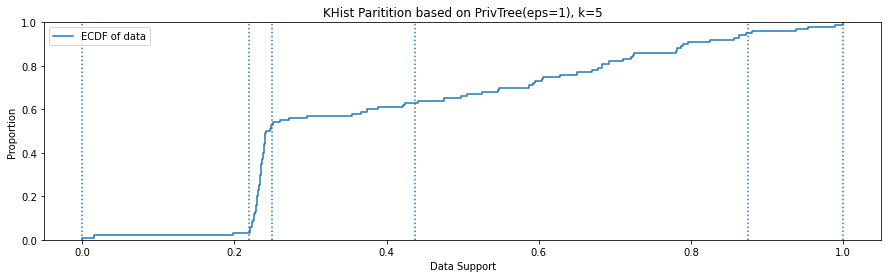

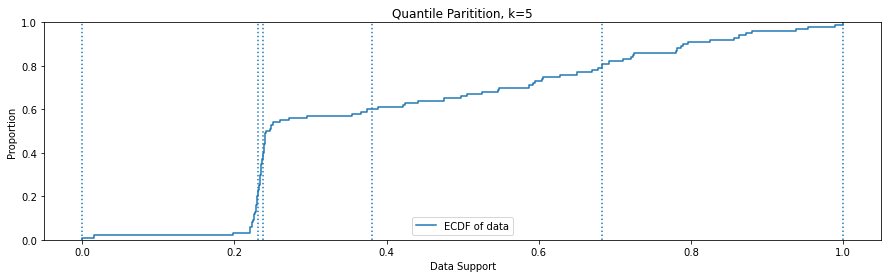

In [129]:
S = np.cumsum(X)
P = np.r_[0, np.cumsum(khist_B)[S-1]]

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

for p in P:
    ax.axvline(p, ls=':')
ax.legend()
    
ax.set_title(f'KHist Paritition based on PrivTree(eps=1), k={k}')
ax.set_xlabel('Data Support')

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

P = np.quantile(A, np.linspace(0,1,k+1))
for p in P:
    ax.axvline(p, ls=':')
ax.legend()
    
ax.set_title(f'Quantile Paritition, k={k}')
ax.set_xlabel('Data Support')

# 1D-Case, adult / capital-gain, Integer Partition

Text(0.5, 1.0, 'ECDF of capital-gain in adult dataset \n x: symlog scale, integer domain')

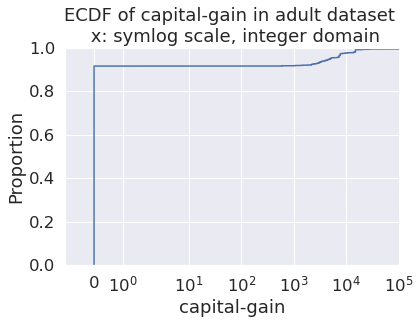

In [286]:
adult = pd.read_csv('./adult/adult.csv')
fig, ax = plt.subplots()
sns.ecdfplot(adult['capital-gain'])
ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.set_title('ECDF of capital-gain in adult dataset \n x: symlog scale, integer domain')

In [287]:
eps = 1.0
A = adult['capital-gain'].values.reshape(-1, 1)
myprivtree = privtree.PrivTree(A, eps, [(0, int(np.max(A)))], ['int'])
G, root = myprivtree.partition()
G = myprivtree.naive_est()

3.0 0 2.0794415416798357


In [288]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
n = len(A)
est_n = root.var.value
df = pd.DataFrame({'lb':[leaf.lb[0] for leaf in leaves], 
                   'ub':[leaf.ub[0] for leaf in leaves], 
                   'real cnt':[leaf.c for leaf in leaves],
                   'guessed cnt':[int(leaf.var.value / est_n * n) for leaf in leaves]})
df.to_csv('temp.csv', index=False)

In [289]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
print(f'# leaves: {len(leaves)}')
khist_A = np.array([leaf.var.value for leaf in leaves])
khist_A = khist_A / khist_A.sum()
khist_B = np.array([leaf.ub[0] - leaf.lb[0] + 1 for leaf in leaves])

losses = []
for k in [5, 10, 15, 18, 20, 50, 100]:
    X, dp = khist.solve_khist(khist_A, khist_B, k)
    losses.append({
        'k': k,
        'loss': dp(len(leaves), k)
    })

    S = np.r_[0, np.cumsum(X)]
    n = len(A)
    est_n = root.var.value
    df = pd.DataFrame({'lb':[leaves[s].lb[0] for s in S[:-1]], 
                       'ub':[leaves[s-1].ub[0] for s in S[1:]], 
                       'real cnt': list(map(np.sum, np.split([leaf.c for leaf in leaves], np.cumsum(X))[:-1])),
                       'guessed cnt': list(map(np.sum, np.split(
                           [int(leaf.var.value / est_n * n) for leaf in leaves], np.cumsum(X))[:-1]))
                      })
    display(df)
    df.to_csv(f'results/k{k}.csv', index=False)
    '''
    fig, axes = plt.subplots(1,2, figsize=(15, 4))
    axes[0].bar(x=df['lb'], width=df['ub']-df['lb'], height=df['real cnt'], align='edge', label='real cnt')
    axes[1].bar(x=df['lb'], width=df['ub']-df['lb'], height=df['guessed cnt'], align='edge', label='guessed cnt')
    for ax in axes:
        ax.legend()
        ax.set_yscale('symlog')
        ax.set_xscale('symlog')
    '''

,k,loss
0,5,2826.539787
1,10,837.879315
2,15,494.379029
3,18,374.590864
4,20,322.444173
5,50,94.857410
6,100,38.879003


Text(0.5, 1.0, 'elbow curve of KHist for capital-gain (eps=1.0)')

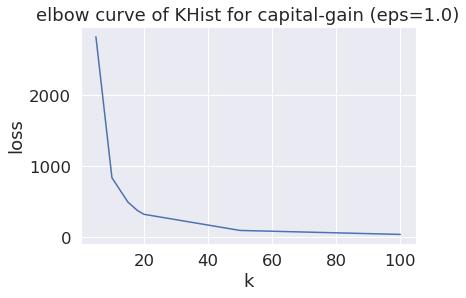

In [290]:
fig, ax = plt.subplots()
losses = pd.DataFrame(losses)
display(losses)
sns.lineplot(data=losses, x='k', y='loss')
ax.set_title('elbow curve of KHist for capital-gain (eps=1.0)')

In [228]:
S

array([  1,   1,   8,  12,  14,  21,  24,  32,  34,  38,  40,  46,  50,
        57,  60,  66,  70,  78,  82,  87,  90,  95,  99, 102, 110, 119,
       122, 131, 137, 139, 142, 148, 151, 159, 161, 167, 171, 179, 182,
       185, 191, 194, 202, 206, 207, 210, 216, 219, 223, 230, 234, 240,
       242, 243, 250, 254, 256, 260, 262, 264, 267, 275, 276, 277, 278,
       282, 286, 288, 297, 300, 304, 306, 309, 314, 317, 318, 319, 321,
       324, 332, 334, 335, 336, 337, 338, 340, 348, 350, 351, 352, 353,
       354, 355, 356, 357, 358, 360, 361, 363, 366, 374])

In [227]:
df.to_csv('k100.csv', index=False)

In [137]:
leaves[4].lb

array([7])

Text(0.5, 0, 'Data Support')

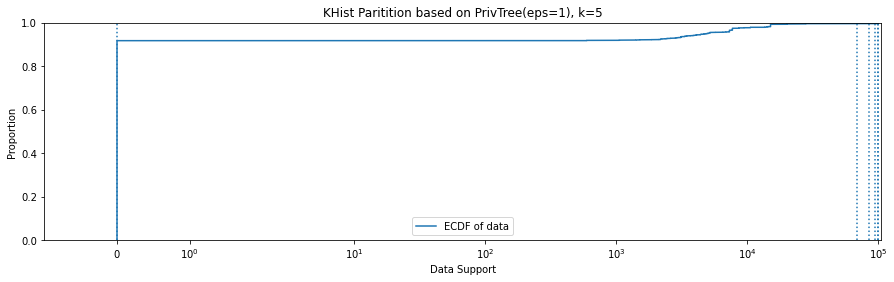

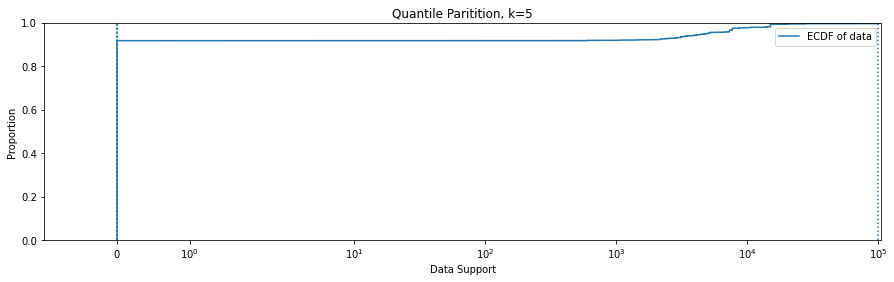

In [107]:
S = np.cumsum(X)
P = np.r_[0, np.cumsum(khist_B)[S-1]]

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

for p in P:
    ax.axvline(p, ls=':')
ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.legend()
    
ax.set_title(f'KHist Paritition based on PrivTree(eps=1), k={k}')
ax.set_xlabel('Data Support')

fig, ax = plt.subplots(figsize=(15, 4))
sns.ecdfplot(A, label='ECDF of data')

P = np.quantile(A, np.linspace(0,1,k+1))
for p in P:
    ax.axvline(p, ls=':')
ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.legend()
    
ax.set_title(f'Quantile Paritition, k={k}')
ax.set_xlabel('Data Support')

# 1D-Case, adult / hours-per-week, Integer Partition

Text(0.5, 1.0, 'ECDF of hours-per-week in adult dataset \n x: symlog scale, integer domain')

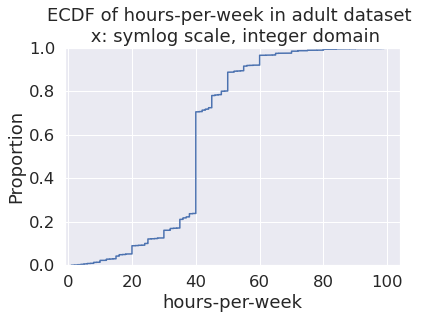

In [293]:
adult = pd.read_csv('./adult/adult.csv')
#display(adult)
fig, ax = plt.subplots()
sns.ecdfplot(adult['hours-per-week'])
#ax.set_xscale('symlog')
ax.set_xlim(-1, None)
ax.set_title('ECDF of hours-per-week in adult dataset \n x: symlog scale, integer domain')

In [294]:
len(adult['hours-per-week'].unique())

94

In [295]:
eps = 1.0
A = adult['hours-per-week'].values.reshape(-1, 1)
myprivtree = privtree.PrivTree(A, eps, [(0, int(np.max(A)))], ['int'])
G, root = myprivtree.partition()
G = myprivtree.naive_est()

3.0 0 2.0794415416798357


In [296]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
n = len(A)
est_n = root.var.value
df = pd.DataFrame({'lb':[leaf.lb[0] for leaf in leaves], 
                   'ub':[leaf.ub[0] for leaf in leaves], 
                   'real cnt':[leaf.c for leaf in leaves],
                   'guessed cnt':[int(leaf.var.value / est_n * n) for leaf in leaves]})
df.to_csv('results/hours-per-week/kinf.csv', index=False)

# leaves: 95
k= 5


,lb,ub,real cnt,guessed cnt
0,0,23,3017,2964
1,24,39,4746,4646
2,40,40,15217,15228
3,41,60,8471,8430
4,61,99,1110,1242


k= 10


,lb,ub,real cnt,guessed cnt
0,0,14,977,954
1,15,23,2040,2010
2,24,31,2233,2199
3,32,39,2513,2447
4,40,40,15217,15228
5,41,47,2573,2573
6,48,50,3365,3363
7,51,60,2533,2494
8,61,75,752,800
9,76,99,358,442


k= 15


,lb,ub,real cnt,guessed cnt
0,0,11,747,733
1,12,19,957,928
2,20,22,1292,1283
3,23,29,1100,1065
4,30,34,1487,1475
5,35,39,2180,2126
6,40,40,15217,15228
7,41,45,2442,2441
8,46,49,677,677
9,50,50,2819,2818


k= 20


,lb,ub,real cnt,guessed cnt
0,0,7,295,290
1,8,14,682,664
2,15,19,727,707
3,20,20,1224,1213
4,21,24,341,331
5,25,29,827,804
6,30,30,1149,1144
7,31,34,338,331
8,35,35,1297,1296
9,36,39,883,830


k= 25


,lb,ub,real cnt,guessed cnt
0,0,7,295,290
1,8,11,452,443
2,12,15,634,616
3,16,19,323,312
4,20,20,1224,1213
5,21,24,341,331
6,25,25,674,666
7,26,29,153,138
8,30,30,1149,1144
9,31,34,338,331


k= 30


,lb,ub,real cnt,guessed cnt
0,0,7,295,290
1,8,10,441,431
2,11,14,241,233
3,15,16,609,599
4,17,19,118,108
5,20,20,1224,1213
6,21,24,341,331
7,25,25,674,666
8,26,29,153,138
9,30,30,1149,1144


k= 50


,lb,ub,real cnt,guessed cnt
0,0,3,91,98
1,4,5,114,110
2,6,7,90,82
3,8,9,163,153
4,10,10,278,278
5,11,12,184,184
6,13,14,57,49
7,15,15,404,395
8,16,16,205,204
9,17,19,118,108


k= 95


,lb,ub,real cnt,guessed cnt
0,0,0,0,12
1,1,1,20,22
2,2,2,32,27
3,3,3,39,37
4,4,4,54,54
...,...,...,...,...
90,91,93,4,8
91,94,96,8,8
92,97,97,2,12
93,98,98,11,12


,k,loss
0,5,11.642862
1,10,4.948341
2,15,3.207148
3,20,2.305160
4,25,1.793939
5,30,1.537817
6,50,1.133112
7,95,1.001343


Text(0.5, 1.0, 'elbow curve of KHist for hours-per-week (eps=1.0)')

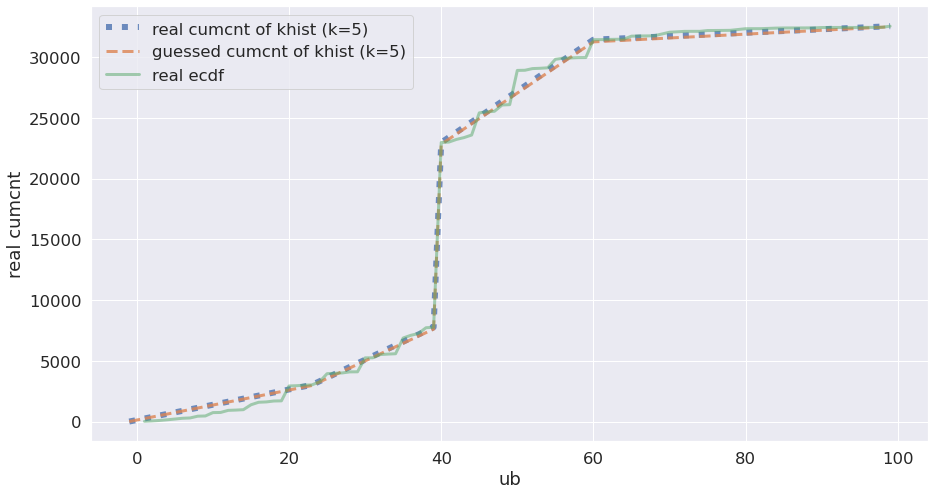

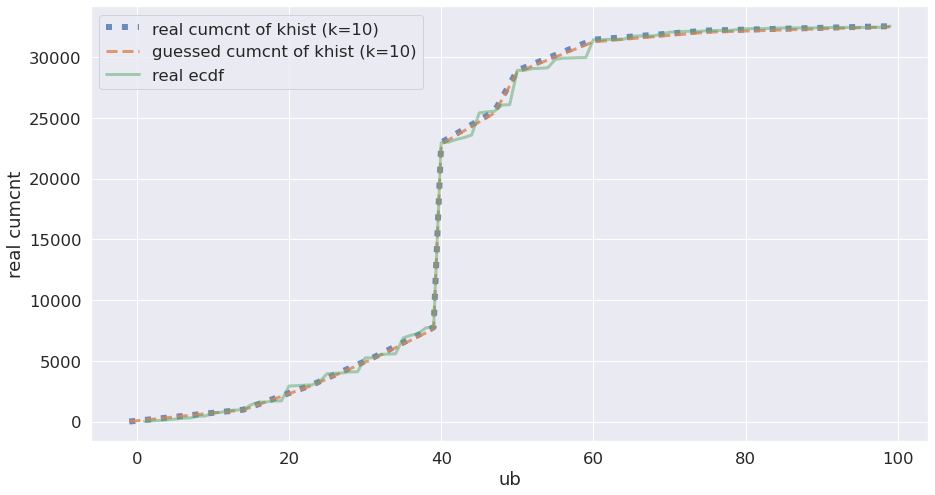

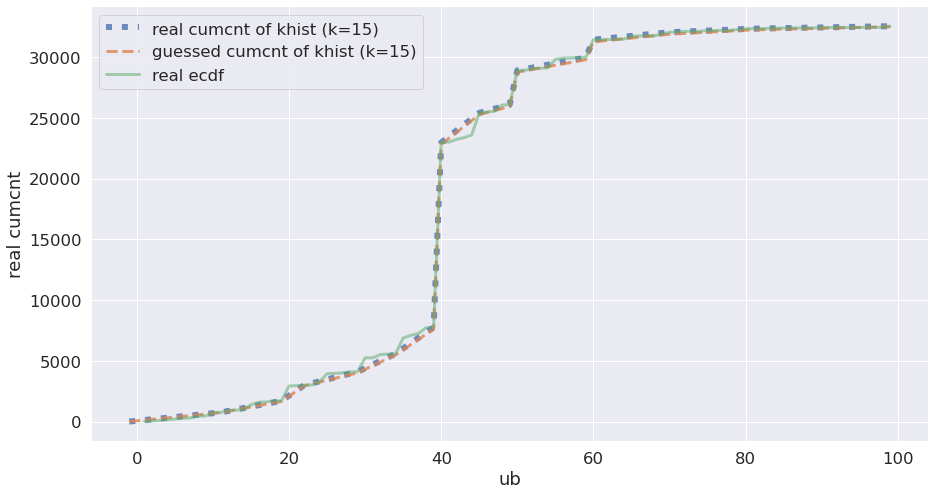

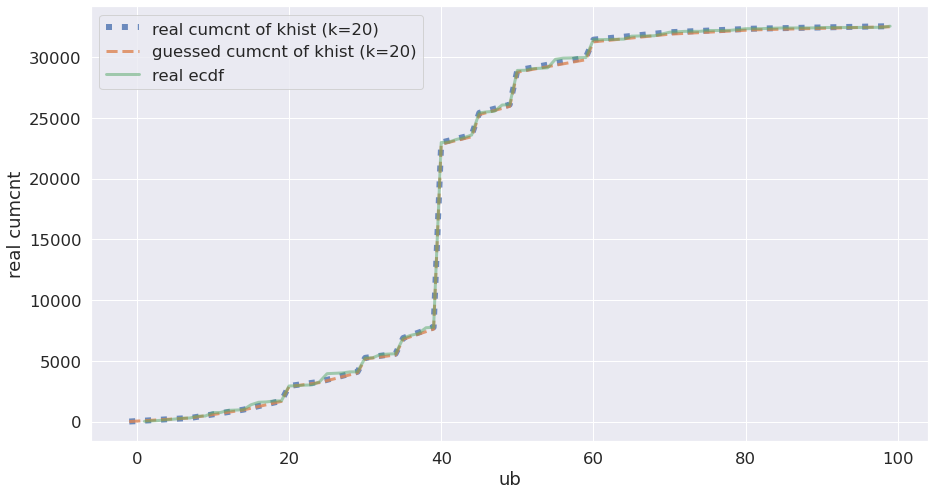

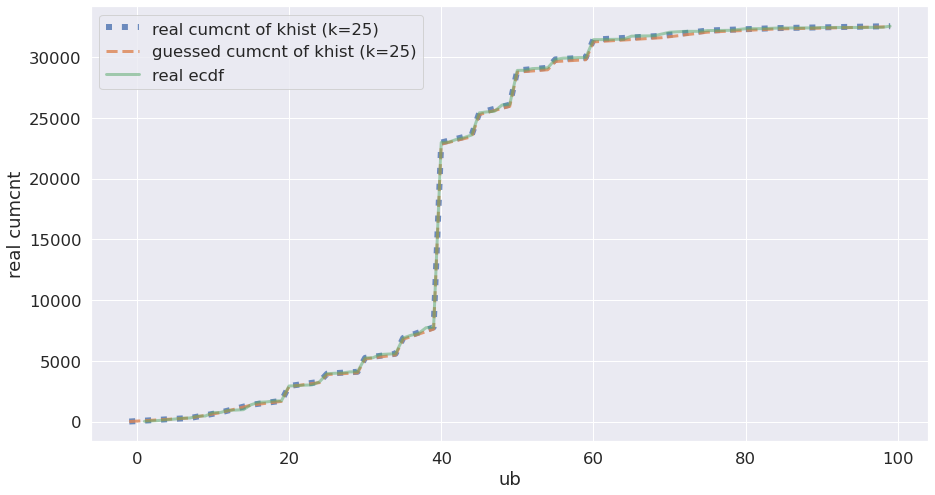

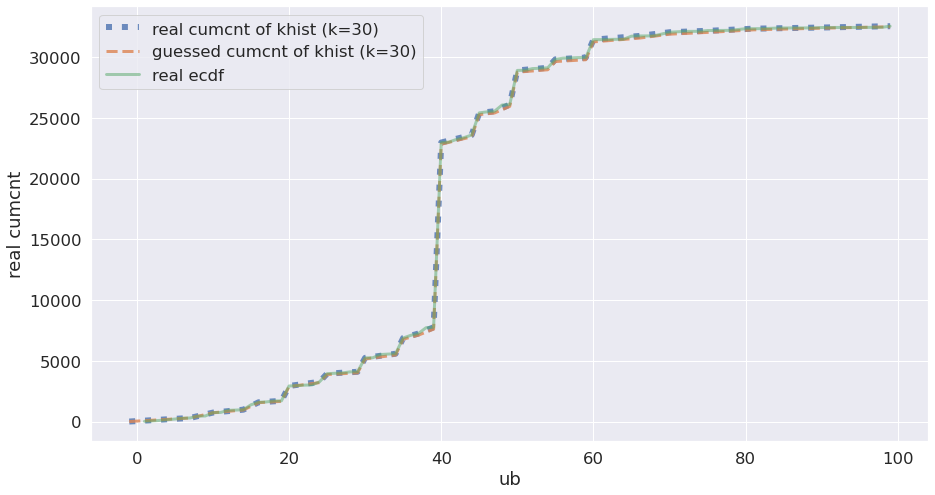

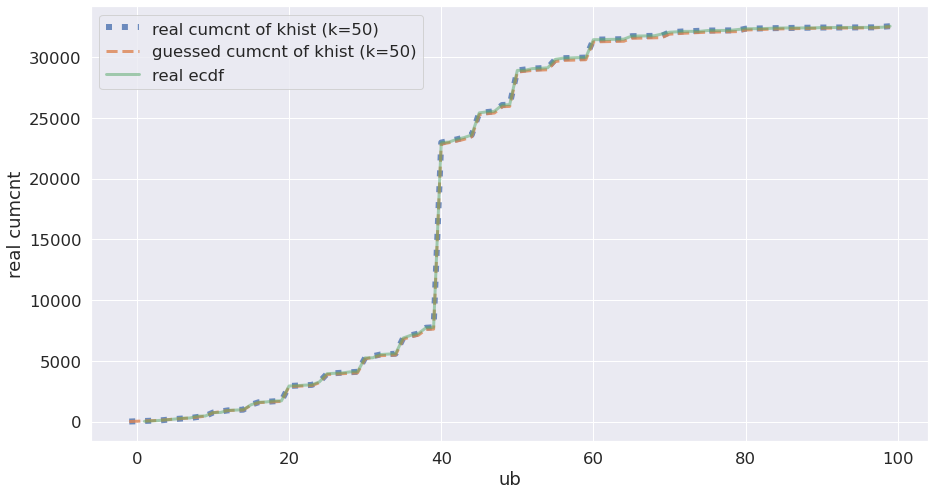

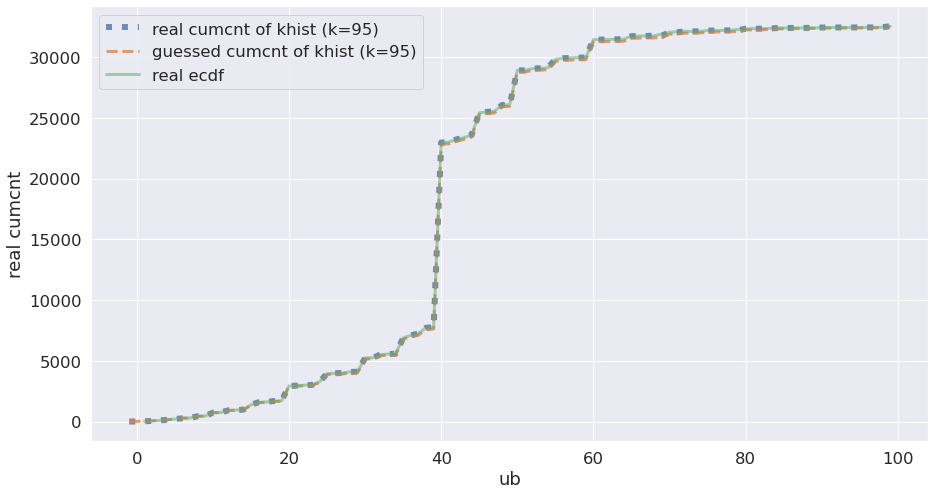

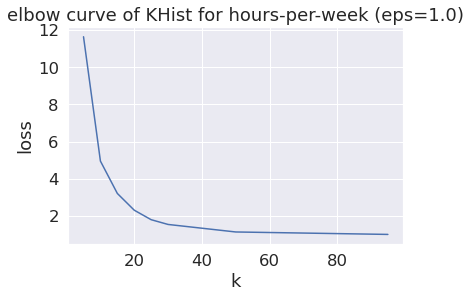

In [297]:
leaves = sorted(privtree.get_leaves(G), key=lambda x: x.lb[0])
print(f'# leaves: {len(leaves)}')
khist_A = np.array([leaf.var.value for leaf in leaves])
khist_A = khist_A / khist_A.sum()
khist_B = np.array([leaf.ub[0] - leaf.lb[0] + 1 for leaf in leaves])

sns.set(font_scale=1.5)
losses = []
for k in [5, 10, 15, 20, 25, 30, 50, len(leaves)]:
    X, dp = khist.solve_khist(khist_A, khist_B, k)
    losses.append({
        'k': k,
        'loss': dp(len(leaves), k)
    })

    S = np.r_[0, np.cumsum(X)]
    n = len(A)
    est_n = root.var.value
    df = pd.DataFrame({'lb':[leaves[s].lb[0] for s in S[:-1]], 
                       'ub':[leaves[s-1].ub[0] for s in S[1:]], 
                       'real cnt': list(map(np.sum, np.split([leaf.c for leaf in leaves], np.cumsum(X))[:-1])),
                       'guessed cnt': list(map(np.sum, np.split(
                           [int(leaf.var.value / est_n * n) for leaf in leaves], np.cumsum(X))[:-1]))
                      })
    print('k=',k)
    display(df)
    df.to_csv(f'results/k{k}.csv', index=False)
    df = pd.concat([pd.DataFrame({'lb': [-1], 'ub': [-1], 'real cnt': [0], 'guessed cnt': [0]}), df])
    df['real cumcnt'] = np.cumsum(df['real cnt'])
    df['guessed cumcnt'] = np.cumsum(df['guessed cnt'])
    fig, ax = plt.subplots(1,1, figsize=(15, 8))
    sns.lineplot(data=df, x='ub', y='real cumcnt', label=f'real cumcnt of khist (k={k})', ls=':', lw=6, alpha=0.8, ax=ax)
    sns.lineplot(data=df, x='ub', y='guessed cumcnt', label=f'guessed cumcnt of khist (k={k})', ls='--', lw=3, alpha=0.8, ax=ax)
    Adf = pd.DataFrame(A, columns=['A'])
    Adf = Adf.groupby('A').size().to_frame('cnt').sort_index().reset_index()
    Adf['cumcnt'] = np.cumsum(Adf.cnt)
    sns.lineplot(data=Adf, x='A', y='cumcnt', label='real ecdf', lw=3, alpha=0.5, ax=ax)
    ax.legend()
    
    
fig, ax = plt.subplots()
losses = pd.DataFrame(losses)
display(losses)
sns.lineplot(data=losses, x='k', y='loss')
ax.set_title('elbow curve of KHist for hours-per-week (eps=1.0)')




# 2D-Case, Heruistic Algorithm

In [87]:
A = np.random.uniform(0, 1, size=(100, 2))
A = np.random.normal(loc=0.5, scale=0.1, size=(100, 2))
A = np.clip(np.random.multivariate_normal(mean=(0.5, 0.5), cov=np.array(((0.1, 0.08), (0.08, 0.1)))/2, size=500), 0, 1)
#A = np.clip(np.random.multivariate_normal(mean=(0.5, 0.01), cov=np.array(((0.1, 0), (0, 0.001)))/2, size=1000), 0, 1)

In [89]:
eps = 1.0
privt = privtree.PrivTree(A, eps)
privt_G, _ = privt.partition()

2.3333333333333335 0 3.2346868426130784


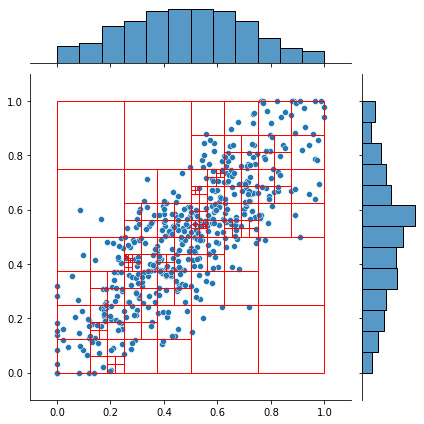

In [90]:
G = privt_G
leaves = [x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]

g = sns.jointplot(x=A[:, 0], y=A[:, 1])
ax = g.ax_joint

for leaf in leaves:
    lb = leaf.lb
    ub = leaf.ub
    #print(leaf.c)
    #print(lb, ub)
    # assume 2d
    rect = patches.Rectangle((lb[0],lb[1]), ub[0]-lb[0], ub[1]-lb[1], edgecolor='r', facecolor="none")
    ax.add_patch(rect)
    #break
    
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(-0.1, 1.1)
plt.show()